In [1]:
#This is a hack to make the %%cpp work inside mybinder.org - ignore
from ROOT import TObject

Welcome to JupyROOT 6.28/06


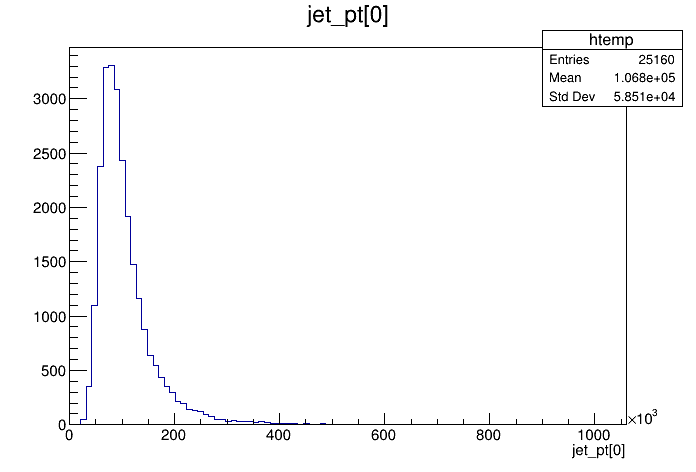

In [2]:
%%cpp
//Recall we can read a file, get the TTree from it and draw something
ttBarFile = TFile::Open("http://opendata.atlas.cern/release/samples/MC/mc_117049.ttbar_had.root");
miniTree = static_cast<TTree*>(ttBarFile->Get("mini;1"));
TCanvas can;
miniTree->Draw("jet_pt[0]");
can.Draw()

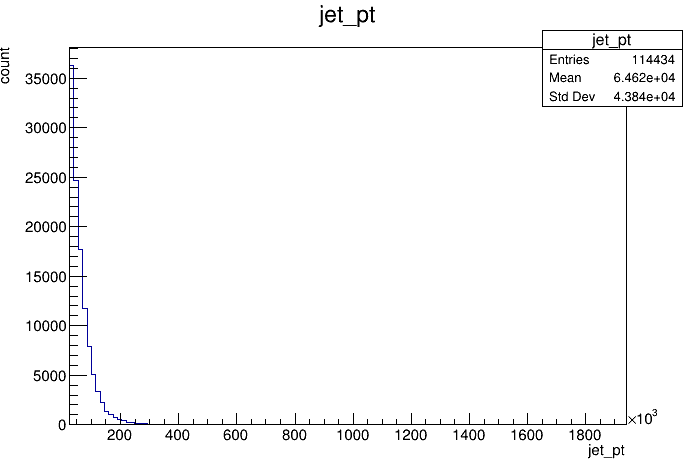

In [3]:
%%cpp
//Another way to do the same thing uses a RDataFrame
//Note we have to explicitly load the library we need - its NOT loaded by default in CLING
gSystem->Load("$ROOTSYS/lib/libROOTDataFrame.so");
ROOT::RDataFrame myDataFrame("mini;1", "http://opendata.atlas.cern/release/samples/MC/mc_117049.ttbar_had.root");
auto myHist = myDataFrame.Histo1D("jet_pt");
can.Clear();
myHist->Draw();
can.Draw()

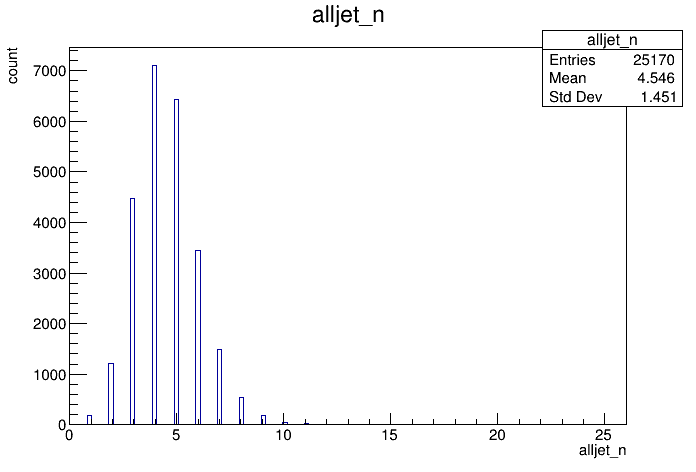

In [4]:
#Lets repeat in python
from ROOT import RDataFrame, TCanvas
myPythonDataFrame = RDataFrame("mini;1", "http://opendata.atlas.cern/release/samples/MC/mc_117049.ttbar_had.root")
myPythonHist = myPythonDataFrame.Histo1D("alljet_n")
myPythonCanvas = TCanvas()
myPythonHist.Draw()
myPythonCanvas.Draw()

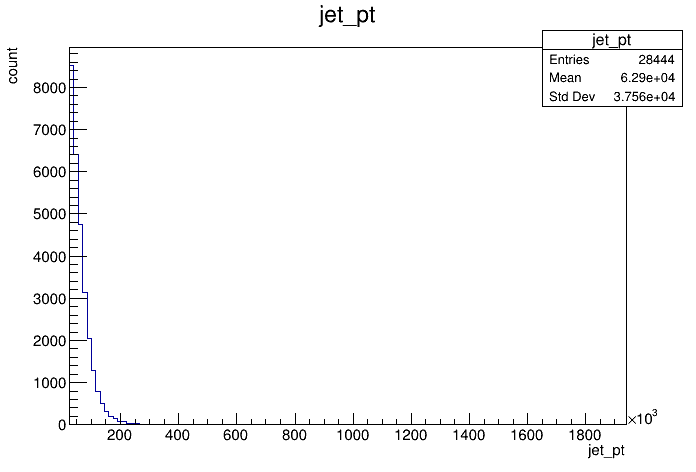

In [5]:
#We see above the number of jets varies by event
#What if we want to plot the jet_pt for events with exactly four jets?
#We do the same thing and add a Filter - the string should be c++ style code (will crash if its invalid..)
myJetPtHist = myPythonDataFrame.Filter("4 == alljet_n").Histo1D("jet_pt")
myJetPtHist.Draw()
myPythonCanvas.Draw()

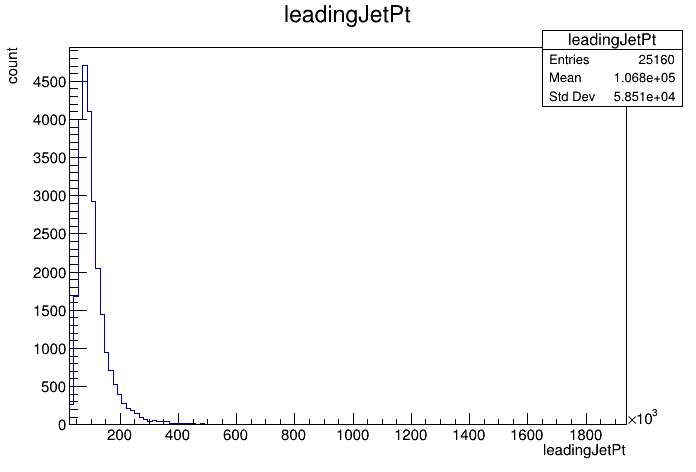

In [6]:
#What if we want to plot the leading jet pt only, rather than pt of all jets? Asking to draw jet_pt[0] won't work
#So instead we have to define the variable ourselves and we also filter the data to remove events without jets
#Otherwise accessing jet_pt[0] would cause a crash due to an invalid entry in the array.
myNewDataFrame = myPythonDataFrame.Filter("alljet_n > 0").Define("leadingJetPt","return jet_pt[0]")
myLeadingJetPtHist = myNewDataFrame.Histo1D("leadingJetPt")
myLeadingJetPtHist.Draw()
myPythonCanvas.Draw()
#We see this is identical to the histogram we made from the TTree at the start of this workbook.

In [7]:
#Task 1 - create a new data frame with a typical semi-leptonic ttbar event selection consisting of
#exactly one lepton, at least four jets and at least one b-tagged jet
#Then plot the HT variable - this is the scalar sum of jet pt and Missing ET
#Hints: Information about the variables in the open data is here:
#http://opendata.atlas.cern/release/2020/documentation/datasets/dataset13.html

In [8]:
%%cpp
//What if we want to filter our data using variables not part of the TTree?
//We use lambda capture functions.
//First define a cut value to use
float ptCut = 20;
//Then define a lambda function - it looks like usual in c++, except for the [&ptCut] which
//"captures" our ptCut variable above and uses it in the function
auto ptCutFunction = [&ptCut](double pt){return pt > ptCut;};
//Then we first make sure we only use data with 2 jets and 1 lepton
auto myFilteredData = myDataFrame.Filter("alljet_n >= 2 && lep_n > 1");
//Now use the lambda function inside the Filter function - just name the function and tell
//it the name of the variable to pass as the argument (i.e. pt)
auto myFilteredDataB = myFilteredData.Define("leadingJetPt","return jet_pt[0]").Filter(ptCutFunction,{"leadingJetPt"});
//filter it again using the second jet pt
auto myFilteredDataC = myFilteredDataB.Define("jetPt2","return jet_pt[1]").Filter(ptCutFunction,{"jetPt2"});


In [9]:
#How do we do the same in python?
#Well it would look like this...
#ptCut = 20
#ptCutFunction = lambda pt, ptCut: pt > ptCut
#But RDataFrame does not support that, instead we use a special syntax to define via c++
import ROOT
ROOT.gInterpreter.Declare("""
auto ptCutFunctionB = [](double pt){return pt > 50;};
""")
myFilteredData = myPythonDataFrame.Define("leadingJetPt","return jet_pt[0]").Filter("ptCutFunctionB(leadingJetPt)")

In [10]:
#Can we make this more pythonic? Yes we can translate to python numpy arrays and eventually a pandas data frame
myArray = myPythonDataFrame.AsNumpy(columns=["alljet_n","jet_pt"])
import pandas
df = pandas.DataFrame(myArray)

In [11]:
#This looks familiar from Lecture 4, where we got a panda dataframe via uproot
df

,alljet_n,jet_pt
0,5,"[73945.09375, 63270.4140625, 39418.984375, 287..."
1,4,"[107119.734375, 105363.75, 36588.48828125, 325..."
2,3,"[53546.4765625, 45670.22265625, 38643.7109375]"
3,4,"[101840.0390625, 78053.1484375, 41085.03125, 3..."
4,4,"[69840.5234375, 46110.9765625, 36343.171875, 3..."
...,...,...
25165,7,"[174389.6875, 71104.6796875, 65230.8125, 60691..."
25166,3,"[69981.5, 63722.06640625, 52493.37109375]"
25167,5,"[190790.890625, 129810.5234375, 99057.140625, ..."
25168,5,"[47075.98828125, 37186.484375, 35792.98828125,..."


In [12]:
#Lets count how many events we have - Count() returns a RResultPtr
#https://root.cern/doc/master/classROOT_1_1RDF_1_1RResultPtr.html
#which has a method GetValue() which returns the value the smart pointer points to
print(myPythonDataFrame.Count().GetValue())
print(myPythonDataFrame.Filter("alljet_n>0").Count().GetValue())

25170
25160


In [ ]:
#Task 2 print out a cutflow (i.e. the number of events passing each cut applied) for a typical semi-leptonic selection.
#Print out the efficiency too (number of events selected/number of events) of each step.